Baseline Model from https://github.com/CVxTz/ECG_Heartbeat_Classification/blob/master/code/baseline_ptbdb.py

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from tensorflow.keras import optimizers, losses, activations, models
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, LearningRateScheduler, ReduceLROnPlateau
from tensorflow.keras.layers import Dense, Input, Dropout, Convolution1D, MaxPool1D, GlobalMaxPool1D, GlobalAveragePooling1D, \
    concatenate
from sklearn.metrics import accuracy_score, f1_score
from sklearn.model_selection import train_test_split
from sklearn.metrics import plot_roc_curve

In [2]:
df_1 = pd.read_csv("../input/ptbdb_normal.csv", header=None)
df_2 = pd.read_csv("../input/ptbdb_abnormal.csv", header=None)
df = pd.concat([df_1, df_2])

df_train, df_test = train_test_split(df, test_size=0.2, random_state=1337, stratify=df[187])


Y = np.array(df_train[187].values).astype(np.int8)
X = np.array(df_train[list(range(187))].values)[..., np.newaxis]

Y_test = np.array(df_test[187].values).astype(np.int8)
X_test = np.array(df_test[list(range(187))].values)[..., np.newaxis]

In [3]:
def get_model():
    nclass = 1
    inp = Input(shape=(187, 1))
    img_1 = Convolution1D(16, kernel_size=5, activation=activations.relu, padding="valid")(inp)
    img_1 = Convolution1D(16, kernel_size=5, activation=activations.relu, padding="valid")(img_1)
    img_1 = MaxPool1D(pool_size=2)(img_1)
    img_1 = Dropout(rate=0.1)(img_1)
    img_1 = Convolution1D(32, kernel_size=3, activation=activations.relu, padding="valid")(img_1)
    img_1 = Convolution1D(32, kernel_size=3, activation=activations.relu, padding="valid")(img_1)
    img_1 = MaxPool1D(pool_size=2)(img_1)
    img_1 = Dropout(rate=0.1)(img_1)
    img_1 = Convolution1D(32, kernel_size=3, activation=activations.relu, padding="valid")(img_1)
    img_1 = Convolution1D(32, kernel_size=3, activation=activations.relu, padding="valid")(img_1)
    img_1 = MaxPool1D(pool_size=2)(img_1)
    img_1 = Dropout(rate=0.1)(img_1)
    img_1 = Convolution1D(256, kernel_size=3, activation=activations.relu, padding="valid")(img_1)
    img_1 = Convolution1D(256, kernel_size=3, activation=activations.relu, padding="valid")(img_1)
    img_1 = GlobalMaxPool1D()(img_1)
    img_1 = Dropout(rate=0.2)(img_1)

    dense_1 = Dense(64, activation=activations.relu, name="dense_1")(img_1)
    dense_1 = Dense(64, activation=activations.relu, name="dense_2")(dense_1)
    dense_1 = Dense(nclass, activation=activations.sigmoid, name="dense_3_ptbdb")(dense_1)

    model = models.Model(inputs=inp, outputs=dense_1)
    opt = optimizers.Adam(0.001)

    model.compile(optimizer=opt, loss=losses.binary_crossentropy, metrics=['acc'])
    model.summary()
    return model

In [4]:
model = get_model()
file_path = "baseline_cnn_ptbdb.h5"
checkpoint = ModelCheckpoint(file_path, monitor='val_acc', verbose=1, save_best_only=True, mode='max')
early = EarlyStopping(monitor="val_acc", mode="max", patience=5, verbose=1)
redonplat = ReduceLROnPlateau(monitor="val_acc", mode="max", patience=3, verbose=2)
callbacks_list = [checkpoint, early, redonplat]  # early

model.fit(X, Y, epochs=1000, verbose=1, callbacks=callbacks_list, validation_split=0.1)

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 187, 1)]          0         
_________________________________________________________________
conv1d (Conv1D)              (None, 183, 16)           96        
_________________________________________________________________
conv1d_1 (Conv1D)            (None, 179, 16)           1296      
_________________________________________________________________
max_pooling1d (MaxPooling1D) (None, 89, 16)            0         
_________________________________________________________________
dropout (Dropout)            (None, 89, 16)            0         
_________________________________________________________________
conv1d_2 (Conv1D)            (None, 87, 32)            1568      
_________________________________________________________________
conv1d_3 (Conv1D)            (None, 85, 32)            3104  

In [22]:
model.load_weights(file_path)

pred_test = model.predict(X_test)
pred_test = (pred_test>0.5).astype(np.int8)

f1 = f1_score(Y_test, pred_test)

print("Test f1 score : %s "% f1)

acc = accuracy_score(Y_test, pred_test)

print("Test accuracy score : %s "% acc)

Test f1 score : 0.9895387541607228 
Test accuracy score : 0.9848849192717279 


In [24]:
from sklearn.metrics import roc_curve
from sklearn.metrics import auc
fpr_keras, tpr_keras, thresholds_keras = roc_curve(Y_test, pred_test)
auc_keras = auc(fpr_keras, tpr_keras)
print("AUROC score : %s "% auc_keras)

AUROC score : 0.9807896770278233 


In [25]:
from sklearn.metrics import roc_curve
from sklearn.metrics import auc
fpr, tpr, thresholds = roc_curve(Y_test, pred_test)
auroc = auc(fpr, tpr)
print("AUROC score : %s "% auroc)

AUROC score : 0.9807896770278233 


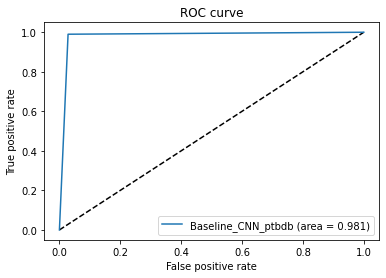

In [26]:
plt.figure(1)
plt.plot([0, 1], [0, 1], 'k--')
plt.plot(fpr_keras, tpr_keras, label='Baseline_CNN_ptbdb (area = {:.3f})'.format(auroc))
plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
plt.title('ROC curve')
plt.legend(loc='best')
plt.savefig('AUROC_CNN_baseline_ptbdb.png')
plt.show()

In [27]:
from sklearn.metrics import precision_recall_curve
from sklearn.metrics import auc
precision, recall, _ = precision_recall_curve(Y_test, pred_test)
# calculate the precision-recall auc
auprc = auc(recall, precision)
print("AUPRC score : %s "% auprc)

AUPRC score : 0.9931459858073138 


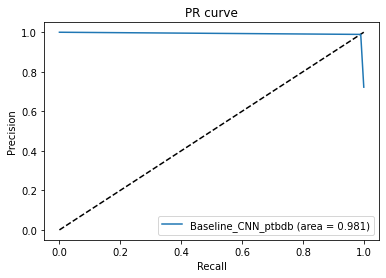

In [28]:
plt.figure(1)
plt.plot([0, 1], [0, 1], 'k--')
plt.plot(recall, precision, label='Baseline_CNN_ptbdb (area = {:.3f})'.format(auroc))
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('PR curve')
plt.legend(loc='best')
plt.savefig('AUPRC_CNN_baseline_ptbdb.png')
plt.show()